This notebook demonstrates the EM algorithm for the noise model.

* **Author**: Jean-Gabriel Young <jean-gabriel.young@uvm.edu>
* **Semester**: Spring 2023
* **License**: CC BY 4.0

# Import modules

In [1]:
# import numerical functions, plotting functions and statistical functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import seaborn as sns
import scipy as sp
import scipy.stats
import pandas as pd
import networkx as nx
import itertools as it
sns.set_style('ticks')

# The problem

We want to estimate a "mean" network $A$ using $N$ samples $(X^1,...,X^N)$, where each sample is a network on the same node set as $A$.

We summarize these samples with a matrix $E$ whose element $E_{ij}$ is the number of observations of an edge between nodes $i$ and $j$, and a number $N$ of observations.

Examples:

1. Measure the same social network $N$ days in a row.
2. Measure $N$ brain networks (same cortical regions in all networks!).

Our approach is parametric and pre-supposes a model where, for a true mean network $A$, edges are included in sample $X^i$ with true-positive rate $\alpha$ and a false-positive rate $\beta$.

To simulate this model, we have the function: (from previous notebooks!)

In [2]:
def generate_error_model(g, alpha, beta):
    n = g.number_of_nodes()

    sample = nx.Graph()
    for i, j in it.combinations(range(n), 2):
        if g.has_edge(i, j):
            if np.random.rand() < alpha:
                sample.add_edge(i, j, etype='tp')
        else:
            if np.random.rand() < beta:
                sample.add_edge(i, j, etype='fp')
    return sample


g = nx.generators.barabasi_albert_graph(100, 1)
N = 3
alpha = 0.9
beta = 0.001
X = [generate_error_model(g, alpha, beta) for t in range(N)]

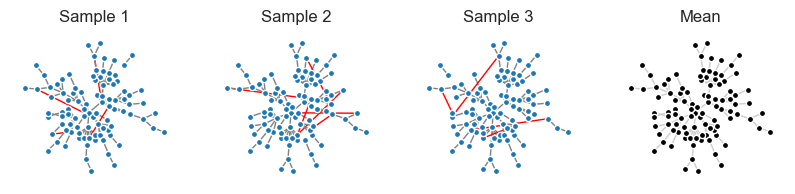

In [3]:
pos = nx.kamada_kawai_layout(g)

plt.figure(figsize=(10, 2))

for t in range(N):
    plt.subplot(1, N + 1, t + 1)
    plt.title('Sample ' + str(t + 1))
    nx.draw(X[t], pos=pos, edgecolors='w', 
            edge_color=['gray' if e[2]['etype']=='tp' else 'r' for e in X[t].edges(data=True)],
            width=1, node_size=20)
    

    
plt.subplot(1, N + 1, N + 1)
plt.title('Mean')
nx.draw(g, pos=pos, node_color='k', edgecolors='w', edge_color='#CCCCCC', width=1, node_size=20)



# Inference


We wish to estimate $A$ and the parameters of the model, like $\alpha$ and $\beta$.

We have seen that this can be done by formulating a joint model for the observed data $E$, the network $A$,
as 

$$P(E,A|\theta)=P(E|A,\theta)P(A|\theta),$$

where $P(A|\theta)$ is an additional model for the network itself, which we have parametrized only with a density $\rho\in[0,1]$, the probability that each edge is included in the network.
With this model the [**EM algorithm**](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) can then be used to recover the network by steadily making improvements to

$$P(E|\theta) = \sum_{{A}} q({A}) \log\frac{P(E,A|\theta)}{q({A})}$$

by  (1: E-step) choosing the best possible distribution over networks $q(A)$ given some estimate of $\theta$, and (2: M-step) choosing the best parameters $\theta=(\alpha,\beta,\rho)$ given our current of the distribution over networks.


##  EM equation

For the measurement model, we have shown how the two steps of the algorithm can be solved analytically. The EM equations for this model (see Newman, Chapter 9, or lecture notes for weeks 5-6) are:

**E-step:**

$$q(\mathbf{a}) = \prod_{i<j} q_{ij}^{a_{ij}}(1-q_{ij})^{1-a_{ij}}$$

where 

$$q_{ij}=\frac{\rho \alpha^{E_{ij}}(1-\alpha)^{N-E_{ij}}}{\rho \alpha^{E_{ij}}(1-\alpha)^{N-E_{ij}} + (1-\rho)\beta^{E_{ij}}(1-\beta)^{N-E_{ij}}}$$

is the probability that there is an edge between nodes $i$ and $j$ given the data $\mathbf{E}$ and a point estimate of the parameters $\alpha,\beta,\rho$, with $\rho$ being a density parameter.

**M-step:**

$$\alpha = \frac{\sum_{i<j}E_{ij} q_{ij} }{N \sum_{i<j}q_{ij}}$$
$$\beta = \frac{\sum_{i<j}E_{ij}(1 - q_{ij}) }{N \sum_{i<j}(1 - q_{ij})}$$
$$\rho = \frac{1}{\binom{n}{2}} \sum_{i<j} q_{ij}$$



## EM functions



### E-Step


For the E-step, the inputs/outputs are:

* **Inputs**: Parameters ($\alpha,\beta,\rho$) and data ($E$ and $N$)
* **Outputs**: A *distribution* $q(a)$.


Because the distribution $q(A)$ is a product of independent Bernoulli trials in our case---$q(a)=\prod_{i<j} q_{ij}^{a_{ij}}(1-q_{ij})^{1-a_{ij}}$---we can store all the information we need about this distribution as the probabilities $\{q_{ij}\}$. We will store this informatino in a symmetric matrix $Q$.

In code:

In [4]:
def e_step(alpha, beta, rho, E, N, n):
    """Compute the probability distribution q(A), i.e., the matrix Q."""
    # note: n, the number of node is passed for clarity. it can be derived from E too.
    Q = np.zeros((n, n))
    for i, j in it.combinations(range(n), 2):
        h = rho * alpha ** E[i, j] * (1 - alpha) ** (N - E[i,j])
        g = (1 - rho) * beta ** E[i, j] * (1 - beta) ** (N - E[i,j])
        Q[i, j] = h / (h + g)
        Q[j, i] = Q[i, j]
    return Q

### M-step

For the M-step, the inputs/outputs are:

* **Input**: A distribution over networks $q(A)$, and data ($E$ and $N$).
* **Output**: Estimates of the parameters ($\alpha,\beta,\rho$), i.e., three scalars.

In code

In [5]:
def m_step(Q, E, N, n):
    """Compute the best values of the parameters given Q."""
    # note: n, the number of node is passed for clarity. it can be derived from E too.
    alpha = np.sum(np.triu(E * Q, 1)) / (N *  np.sum(np.triu(Q, 1)))
    beta = np.sum(np.triu(E * (1 - Q), 1)) / (N *  np.sum(np.triu(1 - Q, 1)))
    rho = 2 * np.sum(np.triu(Q, 1)) / (n * (n - 1))
    return alpha, beta, rho

## Full EM algorithm

Combining the two steps, we have the full algorithm.

In [6]:
def em_algo(E, N, n, theta_0, T):
    """Iterate the EM steps untill convergence.
    
    Parameters
    ----------
    E: data matrix
    N: number of samples
    n: number of nodes
    theta_0: initial parameters (alpha, beta, rho), as a tuple
    T: number of iterations
    """
    # note: n, the number of node is passed for clarity. it can be derived from E too.
    
    # initialize
    alpha, beta, rho = theta_0
    trajectory = [] # store intermediary states
    
    # loop:
    for t in range(T):
        Q = e_step(alpha, beta, rho, E, N, n)
        (alpha, beta, rho) = m_step(Q, E, N, n)
        trajectory.append({"Q": Q, "alpha": alpha, "beta": beta, "rho":  rho})
    
    return trajectory
    

***Note***: For simplicity, the algorithm above loops for a fixed number of steps $T$. In practice, one should use a convergence criterion, like detecting a lack of changes in $\theta$ or $Q$ or in the log-likelihood itself.

# Using the algorithm

To see how the algorithm performs, let's first generate a few more samples from our artificial example. As we will see, the EM algorithm is pretty powerful, so let us add a lot of noise, with a large $\beta$ to make inference a bit more difficult.

In [13]:
# graph
n = 50
g = nx.generators.barabasi_albert_graph(n, 1)

# samples
N = 20
alpha = 0.9
beta = 0.3
X = [generate_error_model(g, alpha, beta) for t in range(N)]

# summarize samples
E = np.zeros((n, n), dtype=int)
for i, j in it.combinations(range(n), 2):
    E[i, j] = np.sum([x.has_edge(i, j) for x in X])
    E[j, i] = E[i, j]

We can see that the measurements are very noisy:

/tmp/ipykernel_56080/2372463914.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  im=plt.imshow(nx.linalg.adjacency_matrix(g).todense(), origin='lower', cmap=plt.cm.gray);


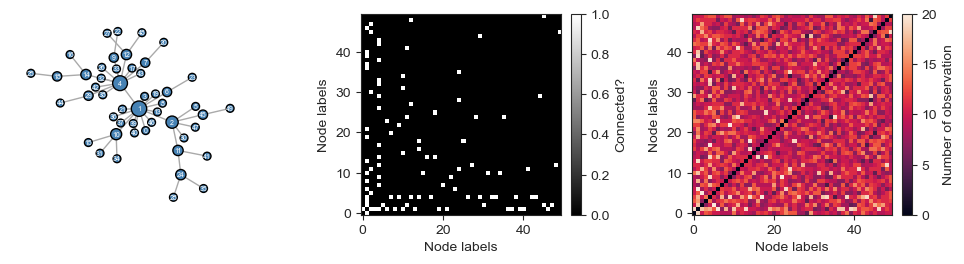

In [14]:
plt.figure(figsize=(10,3))
plt.subplot(131)
np.random.seed(8)
pos=nx.kamada_kawai_layout(g)
nx.draw(g, pos=pos, node_color='#4682B4', edgecolors='k', edge_color='#AAAAAA', node_size=[np.sqrt(g.degree[v]*1000) for v in g.nodes()])
nx.draw_networkx_labels(g, pos=pos, font_size=5, font_color='w')

plt.subplot(132)
im=plt.imshow(nx.linalg.adjacency_matrix(g).todense(), origin='lower', cmap=plt.cm.gray);
plt.colorbar(im, label='Connected?', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

plt.subplot(133)
im = plt.imshow(E, origin='lower',   vmin=0, vmax=N);
plt.colorbar(im, label='Number of observation', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

Let's now apply the algorithm to the matrix $E$. Our goal is to recover the matrix A and the parameters.

We'll run it for 20 steps starting from very "agnostic" initial conditions, $\alpha>\beta$ (meaning we assume that we'll be slightly better at measuring true positive edges than false-positive edges) with $\rho$ close to $1/2$.

In [15]:
T = 20
theta_0 = (0.51,0.49, 0.5)

trajectory = em_algo(E, N, n, 
                     theta_0=theta_0,
                     T=T)

In [16]:
trajectory_alpha = [theta_0[0]] + [t['alpha'] for t in trajectory]
trajectory_beta = [theta_0[1]] + [t['beta'] for t in trajectory]
trajectory_rho = [theta_0[2]] + [t['rho'] for t in trajectory]
trajectory_Q = [t['Q'] for t in trajectory]

The end result looks very much like the underlying truth used to generate these data, see the parameters:

In [17]:
print("True alpha = ", alpha, "| Estimated =", round(trajectory_alpha[-1], 4))
print("True beta = ", beta, "| Estimated =", round(trajectory_beta[-1], 4))
print("True rho = ", nx.density(g), "| Estimated =", round(trajectory_rho[-1], 4))

True alpha =  0.9 | Estimated = 0.4718
True beta =  0.5 | Estimated = 0.6358
True rho =  0.04 | Estimated = 0.7044


And the matrix themselves.

/tmp/ipykernel_56080/917122140.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  im=plt.imshow(nx.linalg.adjacency_matrix(g).todense(), origin='lower', cmap=plt.cm.gray);


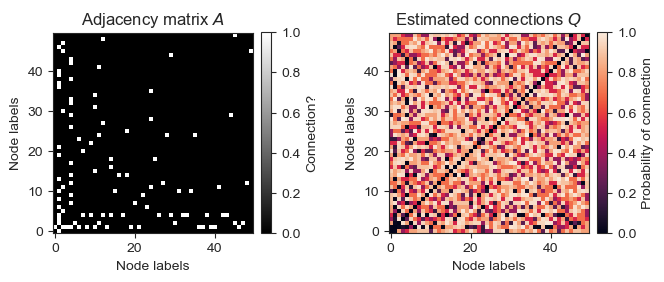

In [18]:
plt.figure(figsize=(7,5))

plt.subplot(121)
plt.title('Adjacency matrix $A$')
im=plt.imshow(nx.linalg.adjacency_matrix(g).todense(), origin='lower', cmap=plt.cm.gray);
plt.colorbar(im, label='Connection?', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

plt.subplot(122)
plt.title('Estimated connections $Q$')
im = plt.imshow(trajectory_Q[-1], origin='lower',   vmin=0, vmax=1);
plt.colorbar(im, label='Probability of connection', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

Observe how our belief about $A$ is now encoded in a matrix $Q$ rather than a point estimate $\hat{A}$.

# Understanding trajectories

## Parameter values

Let's visualize the evolution of the solution in the 3-d space formed by $\alpha,\beta$ and $\rho$:

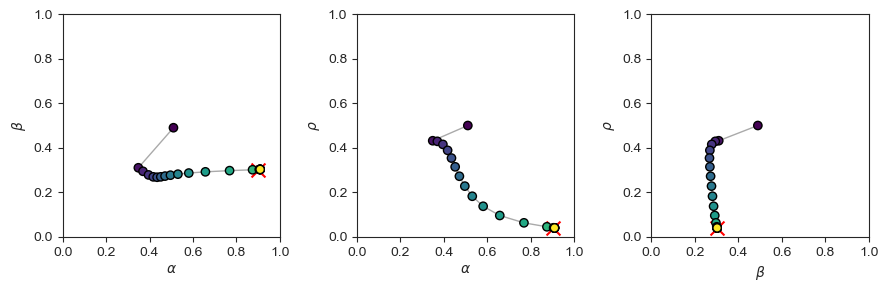

In [30]:
plt.figure(figsize=(9,3))

plt.subplot(131)
plt.scatter(trajectory_alpha, trajectory_beta, color=[plt.cm.viridis(i/T) for i in range(T + 1)], edgecolor='k')
plt.plot(trajectory_alpha, trajectory_beta, c='#AAA', ls='-', lw=1, zorder=-10)
plt.scatter([alpha], [beta], marker='x', c='r', s=100, zorder=-10)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.xlim(0, 1)
plt.ylim(0, 1)


plt.subplot(132)
plt.scatter(trajectory_alpha, trajectory_rho, color=[plt.cm.viridis(i/T) for i in range(T + 1)], edgecolor='k')
plt.plot(trajectory_alpha, trajectory_rho, c='#AAA', ls='-', lw=1, zorder=-10)
plt.scatter([alpha], [nx.density(g)], marker='x', c='r', s=100, zorder=-10)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\rho$")
plt.xlim(0, 1)
plt.ylim(0, 1)


plt.subplot(133)
plt.scatter(trajectory_beta, trajectory_rho, color=[plt.cm.viridis(i/T) for i in range(T + 1)], edgecolor='k')
plt.plot(trajectory_beta, trajectory_rho, c='#AAA', ls='-', lw=1, zorder=-10)
plt.scatter([beta], [nx.density(g)], marker='x', c='r', s=100, zorder=-10)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\rho$")
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout(pad=1)

The color of the dots indicates the iteration, starting from blue and going toward yellow.

We can see that the parameters converge close to the true values, indicated by a red cross.

## Exploring solution quality (advanced)

We can further verify that each step increases the quality of the solution!



Recall that the EM iteratively improves the right-hand side of:
$$\log P(E|\theta) \geq \sum_{A} q(A) \log \frac{P(E,A|\theta)}{q(A)}$$

#### Lower bound:

Without going into detailed proofs, one can show that the bound on the right-hand side can be calculated as:
$$ \sum_{i<j}\Bigg\{ q_{ij}\left[E_{ij}\log \alpha + (N-E_{ij}) \log (1-\alpha) + \log\rho \right] + (1 - q_{ij})\left[E_{ij}\log \beta + (N-E_{ij}) \log (1-\beta) + \log(1-\rho) \right]\Bigg\}+ H(Q)$$
where

$$H(Q)=\sum_{i<j}\left[-q_{ij}\log q_{ij} - (1-q_{ij})\log(1-q_{ij})\right] = \sum_{i<j} h(a_{ij})$$

is the [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of $q(A)$ and $h(a_{ij})$ is known as the [binary entropy](https://en.wikipedia.org/wiki/Binary_entropy_function).

This lower bound is a function of $Q$, the matrix encoding a particular distribution $Q$, as well as of the parameters and data.


#### Marginal likelihood:

Further, we can also calculate the log-likelihood by direct marginalization:


$$\log P(E|\theta) = \log \sum_A P(E,A|\theta) =  \log \prod_{i<j} \left[\alpha^{E_{ij}}(1-\alpha)^{N-E_{ij}}\rho + \beta^{E_{ij}}(1-\beta)^{N-E_{ij}}(1-\rho)\right]$$
$$\quad=
\sum_{i<j} \log \left[\alpha^{E_{ij}}(1-\alpha)^{N-E_{ij}}\rho + \beta^{E_{ij}}(1-\beta)^{N-E_{ij}}(1-\rho)\right]$$

This does not depend upon $A$ because $A$ has been summed over. The only "ghost" of the distribution over networks is $\rho$.


#### Mathematical note:

We will code the above using the identity:

$$\log(x + y) =  \log x + \log(1 + e^{\log y- \log x})$$

This allows us to work with the logarithm of quantity, which is always better for numerical stability.
In particular, $x>y$, the second logarithm should be close to 0 since $\log 1=0$ and the exponential of a negative number is small.


And to simplify the code, we define the function:

$$z(E_{ij}, N, r, p) = E_{ij} \log r + (N - E_{ij}) \log(1-r) + \log p,$$

noting that this expression appears everywhere in the calculation of the lower bound and of the marginal log-likelihood.

(This is because $z$ is the logarithm of the probability mass function of $N$ Bernoulli trials with success probability $r$, $E_{ij}$ of which succeed, plus the logarithm of the associated mixture weight $p$. And the edges' presence/absencs are determined by Bernoulli trials, in each sample, hence why $z$ crops up everywhere).

In code, the lower-bound and marginal log-likelihood are:

In [31]:
def get_z(Eij, N, rate, p):
    # To avoid typo, we define the function that comes up everywhere in the calculation!
    return Eij * np.log(rate) + (N - Eij) * np.log(1 - rate) + np.log(p)
    

def get_lower_bound(E, N, alpha, beta, rho, Q, n):
    """Get lower bound"""
    lb = 0
    for i, j in it.combinations(range(n), 2):
        lb +=       Q[i, j] * get_z(E[i, j], N, alpha, rho)
        lb += (1 - Q[i, j]) * get_z(E[i, j], N, beta, 1 - rho)
        lb += sp.stats.entropy([Q[i, j], 1 - Q[i, j]])
    return lb

def get_marginal_log_likelihood(E, N, alpha, beta, rho, n):
    """Get marginal log-likelihood"""
    loglike = 0
    for i, j in it.combinations(range(n), 2):
        logx = get_z(E[i, j], N, alpha, rho)
        logy = get_z(E[i, j], N, beta, 1 - rho)
        if logx > logy:
            loglike += logx + np.log(1 + np.exp(logy - logx))
        else:
            loglike += logy + np.log(1 + np.exp(logx - logy))
    return loglike

Both of these quantities should increase as the algorithm advances.
Let's re-define the EM algorithm to calculate the quality of the function at each intermediary step (right after E and right after M)

In [32]:
def em_algo_quality(E, N, n, theta_0, T):
    """Run the em algorithm but compute the quality of the solution at each intermediary step."""
    # initialize
    alpha, beta, rho = theta_0
    trajectory_lb = []
    trajectory_ll = []

    # loop:
    for t in range(T):
        # apply e_step and compute the lower bound & log-likelihood
        Q = e_step(alpha, beta, rho, E, N, n)
        trajectory_lb.append(get_lower_bound(E, N, alpha, beta, rho, Q, n))
        trajectory_ll.append(get_marginal_log_likelihood(E, N, alpha, beta, rho, n))

        # apply m_step and compute the lower bound & log-likelihood
        (alpha, beta, rho) = m_step(Q, E, N, n)
        
        trajectory_lb.append(get_lower_bound(E, N, alpha, beta, rho, Q, n))
        trajectory_ll.append(get_marginal_log_likelihood(E, N, alpha, beta, rho, n))

    return (trajectory_lb, trajectory_ll)


In [33]:
T = 20
theta_0 = (0.51,0.49, 0.5)

(trajectory_lb, trajectory_ll) = em_algo_quality(E, N, n, 
                                                 theta_0=theta_0,
                                                 T=T)

Text(0, 0.5, 'Marginal log-likelihood')

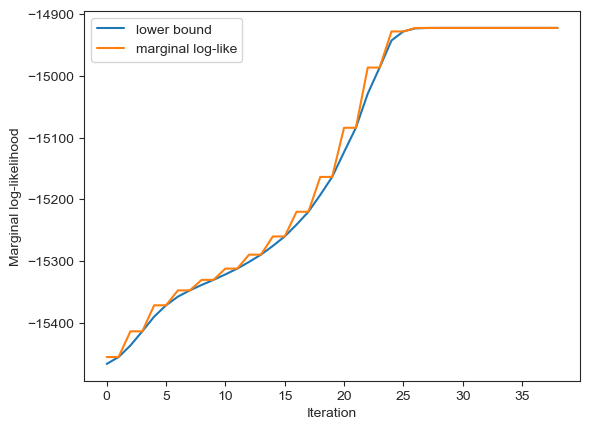

In [34]:
plt.plot(trajectory_lb[1:] ,label='lower bound')
plt.plot(trajectory_ll[1:], label='marginal log-like')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Marginal log-likelihood')

We can see that 

1. The lower bound is always under the log-likelihood

2. The lower bound increases during the E and M step.

3. The marginal log-likelihood $\log P(E|\theta)$ is indifferent to the choice of $Q$, and so does not change during the $E$-step.

# Real world example

To finalize this notebook, let us look at a real world example!

We'll look at the [Reality Mining](https://networks.skewed.de/net/reality_mining) data set.
It is
> "*[a] network of human proximities among students at Massachusetts Institute of Technology (MIT), as measured by personal mobile phones. Nodes represent people (students from the Media Lab and the Sloan Business School) and an edge connects a pair if the two devices made a Bluetooth handshake at the time. Edges are timestamped.*"

We can group edges by day and view each day as a sample.
Further, following a previous analysis [by Newman](https://arxiv.org/abs/1703.07376) we 

> "*... take as our data set the measurements made ... [on] ... eight consecutive Wednesdays in March and April of 2005. (We choose weekly observations to remove weekly periodic effects, and March and April because they fall during the university term.*"

In [40]:
# load edge list
df = pd.read_csv('rm_edges.csv', comment="#", names=["source", "target", "weight", "time"])
# convert unix timestamps to days
df['date'] = pd.to_datetime(df['time'], unit='s').dt.date


# loop over days and create subgraph for each day
X_rm = []
n_rm = max(df['source']) + 1
for day in set(df['date']):
    # only keep wednesday in april and march
    if day.weekday() == 2 and day.month in [3, 4]:
        subdf = df[df['date'] == day]
        g_rm = nx.DiGraph()
        g_rm.add_nodes_from(range(n_rm))
        g_rm.add_edges_from(list(zip(subdf['source'], subdf['target'])))
        X_rm.append(g_rm.copy())

We then extract the matrix $E$ from the data:

In [42]:
E_rm = np.zeros((n_rm, n_rm), dtype=int)
for i, j in it.combinations(range(n_rm), 2):
    for x in X_rm:
        if x.has_edge(i, j) or x.has_edge(j, i):
            E_rm[i, j] += 1
            E_rm[j, i] += 1

And we run the EM algorithm again:

In [43]:
T_rm = 50
N_rm = len(X_rm)
theta_0 = (0.51,0.49, 0.5)

(trajectory_lb, trajectory_ll) = em_algo_quality(E_rm, N_rm, n_rm, 
                                                 theta_0=theta_0,
                                                 T=T_rm)
trajectory = em_algo(E_rm, N_rm, n_rm, 
                     theta_0=theta_0,
                     T=T_rm)

trajectory_alpha = [theta_0[0]] + [t['alpha'] for t in trajectory]
trajectory_beta = [theta_0[1]] + [t['beta'] for t in trajectory]
trajectory_rho = [theta_0[2]] + [t['rho'] for t in trajectory]
trajectory_Q = [t['Q'] for t in trajectory]

<IPython.core.display.Javascript object>


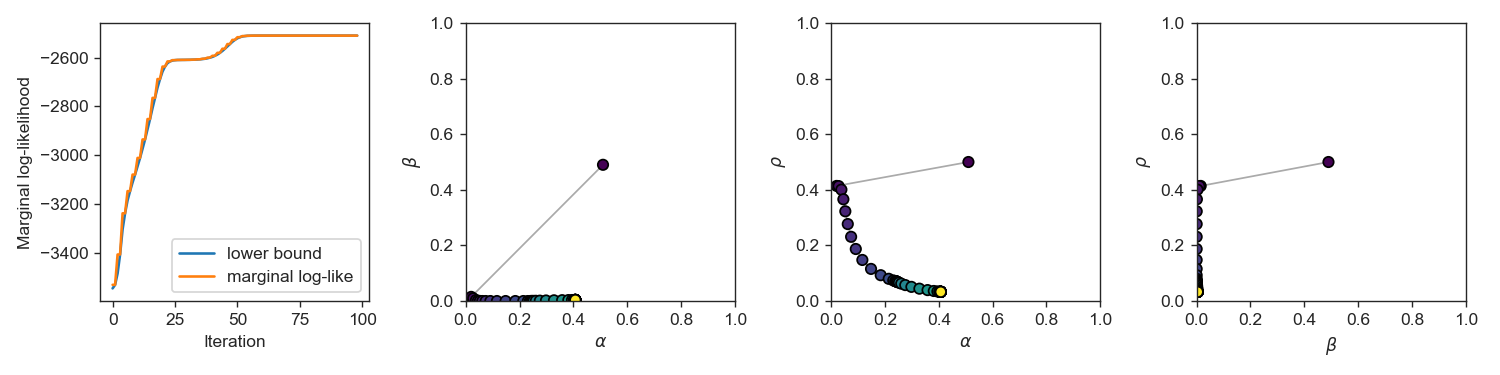

In [44]:
plt.figure(figsize=(12,3))

plt.subplot(141)
plt.plot(trajectory_lb[1:] ,label='lower bound')
plt.plot(trajectory_ll[1:], label='marginal log-like')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Marginal log-likelihood')

plt.subplot(142)
plt.scatter(trajectory_alpha, trajectory_beta, color=[plt.cm.viridis(i/T_rm) for i in range(T_rm + 1)], edgecolor='k')
plt.plot(trajectory_alpha, trajectory_beta, c='#AAA', ls='-', lw=1, zorder=-10)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.xlim(0, 1)
plt.ylim(0, 1)


plt.subplot(143)
plt.scatter(trajectory_alpha, trajectory_rho, color=[plt.cm.viridis(i/T_rm) for i in range(T_rm + 1)], edgecolor='k')
plt.plot(trajectory_alpha, trajectory_rho, c='#AAA', ls='-', lw=1, zorder=-10)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\rho$")
plt.xlim(0, 1)
plt.ylim(0, 1)


plt.subplot(144)
plt.scatter(trajectory_beta, trajectory_rho, color=[plt.cm.viridis(i/T_rm) for i in range(T_rm + 1)], edgecolor='k')
plt.plot(trajectory_beta, trajectory_rho, c='#AAA', ls='-', lw=1, zorder=-10)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\rho$")
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout(pad=1)

<IPython.core.display.Javascript object>


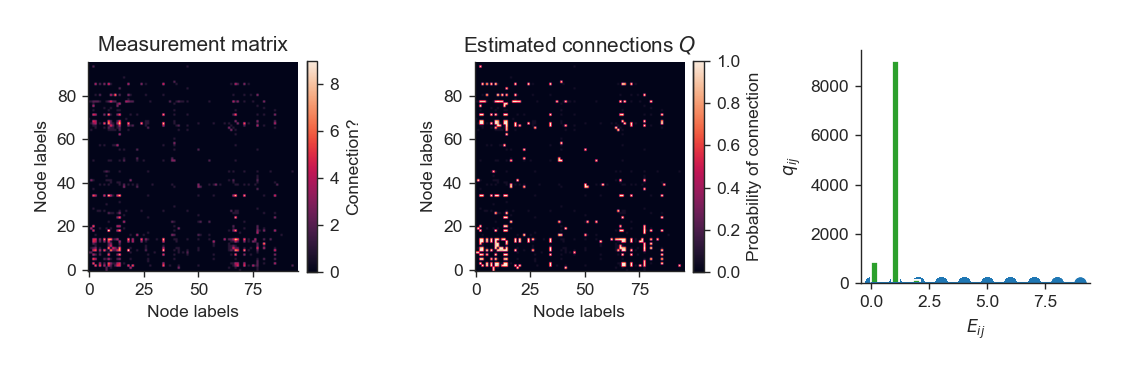

In [45]:
plt.figure(figsize=(9,3))

plt.subplot(131)
plt.title('Measurement matrix')
im=plt.imshow(E_rm, origin='lower');
plt.colorbar(im, label='Connection?', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

plt.subplot(132)
plt.title('Estimated connections $Q$')
im = plt.imshow(trajectory_Q[-1], origin='lower',   vmin=0, vmax=1);
plt.colorbar(im, label='Probability of connection', fraction=0.046, pad=0.04)
plt.xlabel('Node labels')
plt.ylabel('Node labels')
plt.tight_layout(pad=2)

plt.subplot(133)
plt.scatter(E_rm.flatten(), trajectory_Q[-1].flatten())
plt.plot(sorted(E_rm.flatten()), sorted(trajectory_Q[-1].flatten()))
plt.xlabel(r'$E_{ij}$')
plt.ylabel(r'$q_{ij}$')
sns.despine()

plt.tight_layout(pad=2)

In [70]:
def sample_from_distribution(Q, n):
    g = nx.Graph()
    g.add_nodes_from(range(n))
    for i, j in it.combinations(range(n), 2):
        if np.random.rand() < Q[i, j]:
            g.add_edge(i, j)
    return g


In [73]:
k = [nx.degree(sample_from_distribution(trajectory_Q[-1], n), 0) for _ in range(10000)]

In [76]:
np.mean(k)

0.9277

In [78]:
max(k)

3

In [77]:
np.std(k)

0.3047502420015446

# Bonus: The impact of initial conditions

You can use the widget below to explore the impact of initial conditions!

In [36]:
from ipywidgets import *
%matplotlib notebook

<IPython.core.display.Javascript object>


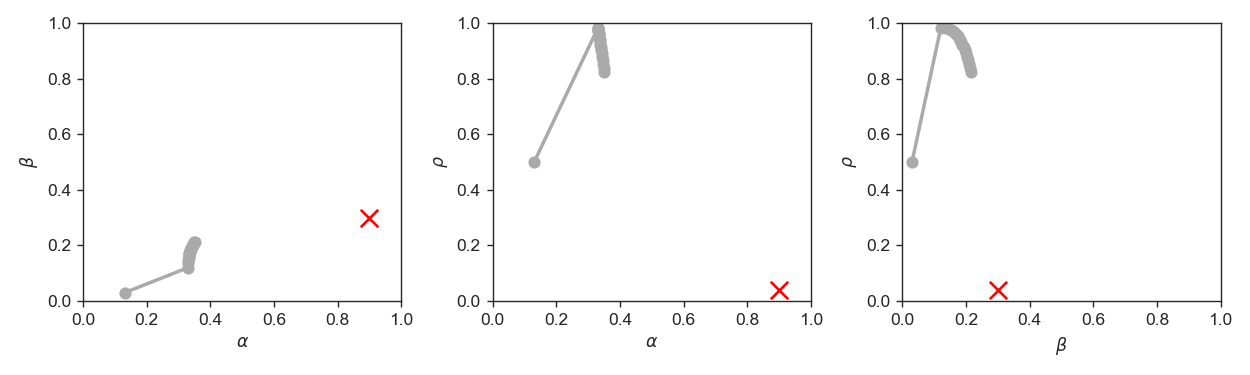

interactive(children=(FloatSlider(value=0.51, description='a0', max=1.0, min=0.01, step=0.01), FloatSlider(val…

In [38]:
def create_plot(axes, trajectory, T):
    [ax1, ax2, ax3] = axes
    trajectory_alpha = [theta_0[0]] + [t['alpha'] for t in trajectory]
    trajectory_beta = [theta_0[1]] + [t['beta'] for t in trajectory]
    trajectory_rho = [theta_0[2]] + [t['rho'] for t in trajectory]  
    ab_p, = ax1.plot(trajectory_alpha, trajectory_beta, c='#AAA', ls='-', lw=2, marker='o', zorder=-10)
    ax1.scatter([alpha], [beta], marker='x', c='r', s=100, zorder=-10)
    ax1.set_xlabel(r"$\alpha$")
    ax1.set_ylabel(r"$\beta$")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ar_p, = ax2.plot(trajectory_alpha, trajectory_rho, c='#AAA', ls='-', lw=2, marker='o', zorder=-10)
    ax2.scatter([alpha], [nx.density(g)], marker='x', c='r', s=100, zorder=-10)
    ax2.set_xlabel(r"$\alpha$")
    ax2.set_ylabel(r"$\rho$")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    br_p, = ax3.plot(trajectory_beta, trajectory_rho, c='#AAA', ls='-', lw=2, marker='o', zorder=-10)
    ax3.scatter([beta], [nx.density(g)], marker='x', c='r', s=100, zorder=-10)
    ax3.set_xlabel(r"$\beta$")
    ax3.set_ylabel(r"$\rho$")
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    plt.tight_layout(pad=1)
    return  ab_p,  ar_p,  br_p

def update_plot(theta_0, trajectory, ab_p, ar_p, br_p):
    trajectory_alpha = [theta_0[0]] + [t['alpha'] for t in trajectory]
    trajectory_beta = [theta_0[1]] + [t['beta'] for t in trajectory]
    trajectory_rho = [theta_0[2]] + [t['rho'] for t in trajectory]
    ab_p.set_xdata(trajectory_alpha)
    ab_p.set_ydata(trajectory_beta)
    ar_p.set_xdata(trajectory_alpha)
    ar_p.set_ydata(trajectory_rho)
    br_p.set_xdata(trajectory_beta)
    br_p.set_ydata(trajectory_rho)

fig = plt.figure(figsize=(10 ,3))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

T = 200
theta_0 = (0.51,0.49, 0.5)

trajectory = em_algo(E, N, n, 
                     theta_0=theta_0,
                     T=T)

ab_p, ar_p, br_p = create_plot([ax1,ax2,ax3], trajectory, T)

# update function for changing values of the parameters
def update(a0, b0, r0):
    theta_0 = (a0, b0, r0)
    trajectory = em_algo(E, N, n, 
                         theta_0=theta_0,
                         T=20)
    update_plot(theta_0, trajectory, ab_p, ar_p, br_p)

# add interactivity
interact(update,
         a0=FloatSlider(min=0.01, max=1, value=0.51, step=0.01),
         b0=FloatSlider(min=0.01, max=1, value=0.49, step=0.01),
         r0=FloatSlider(min=0.01, max=1, value=0.5, step=0.01));

In [ ]:
α